# Getting Started - Vanillix Tutorial

In this tutorial, we'll demonstrate how to use the basic functionalities of our **AUTOENCODIX** pipeline.  
We’ll cover the general workkflow, show how to work with custom classes, and highlight the pipeline’s flexibility.  
**AUTOENCODIX** supports far more functionality than shown here, so we’ll also point to advanced tutorials where relevant.  

**IMPORTANT**

> This tutorial serves two purposes: (a) introducing the framework in general, and (b) presenting the Vanillix pipeline.  
> For other architectures (e.g., Varix or Ontix), we’ll skip the general concepts and focus only on their specifics.  
> To get a solid overview of the framework, we recommend starting here. We’ll include this note in other tutorials as well, so you can always find the right entry point.

---
## What You'll Learn

You’ll learn how to:

1. **Initialize** the pipeline with a pandas DataFrame. <br><br>
2. Understand the **pipeline steps**. <br><br>
3. Access the pipeline **results** (latent spaces, losses, etc.). <br><br>
4. **Visualize** outputs effectively. <br><br>
5. Apply **custom parameters**. <br><br>
6. **Save, load, and reuse** a trained pipeline. <br><br>

---

Let’s get started! 🚀

## 1) Initialization

To get started, you need three things:  
- A dataset  
- A configuration object  
- The Vanillix pipeline  

---

#### 📊 Dataset
We allow a variety of inputs (see [1]).  
Here, we demonstrate how to use the pipeline with pandas DataFrames.  

We prepared three mock DataFrames to simulate a multi-omics use case:  
- RNA: `raw_rna`  
- Protein: `raw_protein`  
- Clinical metadata: `annotation`  

For simplicity, we assume paired metadata.  
For handling unpaired data, see [1] or [2]. <br><br>

---

#### ⚙️ Configuration Object
We use the pre-set parameters in `VanillixConfig`.  

Additionally, we define a `DataCase`, which tells the pipeline what kind of data to expect.  
In this case: `MULTI_BULK`.  

This can be any tabular data and does not have to be bulk sequencing data (we may rename this soon).  
For more details on `DataCase`, refer to [1]. <br><br>

---

#### 🪈 Vanillix Pipeline
Finally, we import `Vanillix` from our package.  

Each autoencoder architecture comes with a corresponding `pipeline`, which handles the complete analysis process—from preprocessing to evaluation.  
All autoencoders share this unified pipeline interface, which we’ll explore in the next sections. <br><br>

---

[1] Tutorials/DeepDives/InputDataTutorials.ipynb <br>  
[2] Tutorials/PipelineTutorials/XModalix.ipynb <br>


### 1.1) Inspect Data
Before initializing the pipeline, we’ll show what the input data can look like.  
This should help when working with your own data later.


In [1]:
from autoencodix.utils.example_data import raw_protein, raw_rna, annotation

print(f"Type of raw_rna input: {type(raw_rna)}")

Type of raw_rna input: <class 'pandas.core.frame.DataFrame'>


In [2]:
raw_rna.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_90,gene_91,gene_92,gene_93,gene_94,gene_95,gene_96,gene_97,gene_98,gene_99
sample_0,-0.693594,-0.473079,0.676121,-0.147388,1.201123,-0.414951,0.753255,-1.108531,2.158595,2.086612,...,0.393002,1.086796,-4.323870,2.633942,2.448690,0.091798,2.143187,3.864588,4.332923,-2.012073
sample_1,-7.717414,4.786169,-5.157288,-2.602279,-0.652874,-0.199347,0.883363,-1.917114,2.130440,2.577293,...,-1.764460,1.574903,-6.280627,0.727504,3.392857,1.263027,0.853917,-3.103998,0.276629,-2.708227
sample_2,3.318892,-2.814952,5.125116,-0.222650,1.384565,-5.355473,-2.930422,-1.684189,4.366761,-0.364140,...,0.055857,-0.903358,1.608255,4.002976,0.399693,-0.791146,-2.655789,-0.346798,0.118127,-0.097970
sample_3,0.305501,-2.003316,-5.919967,3.262441,-3.607759,4.005525,3.349946,0.840550,0.173683,-4.018448,...,0.866646,5.055061,-1.797290,-3.199909,3.422235,2.897288,1.775569,0.937340,-2.042406,2.651122
sample_4,-2.942519,1.831377,-1.003791,3.505788,-0.765147,-2.217828,-2.149387,1.377427,-0.134418,1.960087,...,-4.148493,1.730545,-3.276235,0.263396,1.315254,-1.933574,0.764190,-0.877114,-2.640165,-5.108126


In [3]:
annotation.head()

,condition,batch,quality_score
sample_0,condition_0,batch_3,0.883087
sample_1,condition_0,batch_2,0.884084
sample_2,condition_1,batch_2,0.971995
sample_3,condition_1,batch_1,0.718440
sample_4,condition_0,batch_3,0.854322


### 1.2) Initialize Pipeline
In this step, we import the pipeline, configuration, and data classes, and show how to feed pandas DataFrames into the pipeline.  

We use the `DataPackage` class for this purpose. In our case, we fill the attribute `multi_bulk` with a dictionary of pandas DataFrames.  
*Note:* the term *multi* may be misleading—you can also provide just a single DataFrame.  

Metadata is also passed as a dictionary to the `DataPackage`.  
Here, we have one annotation DataFrame for both data modalities (RNA and protein), so we use the identifier `"paired"` as the key.  
Otherwise, you would use the same keys as for the actual data, e.g.:  
```python
{"rna": rna_annotation, "protein": protein_annotation}


In [4]:
import autoencodix as acx
from autoencodix.data.datapackage import DataPackage
from autoencodix.configs.vanillix_config import VanillixConfig
from autoencodix.configs.default_config import DataCase

# If your data is stored in pandas DataFrames, you can easily pass them to our custom DataPackage.
# For any tabular data that is not single-cell, provide them as a dictionary to the "multi_bulk" attribute of DataPackage.
# Note: "multi" might be misleading—it's valid to provide just one modality (1–n data modalities).
# Here we assume paired metadata. If you have separate metadata for each modality, use the same dict keys as in multi_bulk, e.g.:
# annotation = {"rna": rna_annotation, "protein": protein_annotation}
my_datapackage: DataPackage = DataPackage(
    multi_bulk={"rna": raw_rna, "protein": raw_protein},
    annotation={"paired": annotation},
)

myconfig: VanillixConfig = VanillixConfig(data_case=DataCase.MULTI_BULK, epochs=30)
vanillix = acx.Vanillix(data=my_datapackage, config=myconfig)


in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>




## 2) Pipeline Steps

Next, we explain the four main steps of our pipeline:

1. Preprocess
2. Fit
3. Predict
4. Visualize

We can run all steps together with the `run` step.

### 2.1) Preprocess

If you're familiar with `AUTOENCODIX 1.0`, this is similar to `make data` in the old framework.  
In case you don't want to have any preprocessing, you can set `skip_preprocessing=True` in the config object.  
ATTENTION: This could lead to `RunTimeErrors` if you violate assumptions like NaN-free data, which we'll handle in preprocessing.  
See Tutorial [1] for details on data requirements and assumptions.
#### 🔗 Data Pairing

If you have multiple data modalities, i.e., mRNA and CNA data, and you work with a pipeline that requires paired data (Vanillix, Varix, Ontix, Disentanglix), we drop all samples that are not present in all data modalities.
If you want to include unpaired data, please refer to [2] and [3].

#### 🧼 Data Cleaning

This step acts as a safety net to avoid runtime errors later in the pipeline. Here, we simply drop columns with NaN values.
Ideally, you’ve already cleaned the data before putting it into our pipeline if you want more sophisticated handling of NaNs.
**Note:** For metadata, we allow NaNs as long as they’re not specified in the config as relevant columns (see [4]).

#### ✂️ Splitting

We designed the preprocessing pipeline to avoid data leakage, so almost all preprocessing transformations are applied after splitting the data.
The only exception is filtering cells and log-transforming SingleCell data (if not already done by you).
The default behavior is to split your input data into three splits: train, validation, and test. You can define the ratio via the Config (see [4]) or, for some pipelines, provide a custom split (see [1]).
Additionally, you always pass unseen data to the `predict` step of the pipeline.

#### 🗂️ Filtering

We filter the columns of the train set and apply the learned filtering to the validation and test sets. The filtering method and the number of features to keep can be defined in the config.

The filtering method can be set per data modality, but we recommend keeping it consistent.
If you work with multiple data modalities and provide a number for `k_filter` (e.g., 1000), this will be the total number of features across all data modalities. For example, you may have 500 features for data modality A and 500 features for data modality B.

We provide the following options for filtering:

- `VAR` – Select features with the highest variance
- `MAD` – Select features with the highest median absolute deviation
- `CORR` – Select features based on correlation
- `VARCORR` – Combination of variance and correlation
- `NOFILT` – No filtering applied
- `NONZEROVAR` – Select features with non-zero variance

#### 📏 Scaling
After the filtering step, we scale the data. We fit the scaler on the train set and apply the learned transformations to the validation and test sets.  

Different scaling methods can be applied per data modality, but we strongly recommend setting this globally via the `scaling` parameter. The default is `StandardScaler`.  

We provide the following options for scaling:  
- `STANDARD` – Standard scaling (mean = 0, variance = 1)  
- `MINMAX` – Min-max scaling to range [0, 1]  
- `ROBUST` – Robust scaling using median and interquartile range  
- `MAXABS` – Scaling by the maximum absolute value  
- `NONE` – No scaling applied

#### 🐍 Transforming to PyTorch Dataset 
In the last step, we transform the data to a custom PyTorch Dataset class. 
For the Vanillix pipeline we concat the different data modalites and store them in the data attribute of Dataset class.  
Now the data is ready to serve as input for our PyTorch models.

---

[1] Tutorials/DeepDives/InputDataTutorials.ipynb <br>
[2] Tutorials/PipelineTutorials/XModalix.ipynb <br>
[3] Tutorials/PipelineTutorials/Stackix.ipynb <br>
[4] Tutorials/DeepDives/ConfigTutorial.ipynb <br>

#### 🖥️ In Code

All the above steps run with one command in our pipeline:

In [5]:
# This does not return anything, the step updates internal attributes:
# It sets the private _datasets attribute
# It populates the results.datasets attribute with the preprocessed and transformed PyTorch Datasets (1 for each split)
vanillix.preprocess()

--- Running Pairing-Aware Split ---
Identified 500 fully paired samples across all modalities.
Identified 0 samples present in at least one, but not all, modalities.
Successfully generated synchronized indices for all modalities.


### 2.2) The Fit Step
The fit step trains the autoencoder architecture and caputers an extensive set of training dynamics.  
The training and models itself are highly customizibale (n_layers, latent_dim, epochs, learning_rate, etc), refer to [section 5](#5-customize) or Tutorial [4] for even more details.  
During training, we caputure losses, latentspaces and reconstructions for each checkpoint epoch and store them in our result object.

---
[4] Tutorials/DeepDives/ConfigTutorial.ipynb <br>


In [6]:
# job of old make model
# calls self.Trainer class to init and train model
# populates self._model attribute with trained model
# populates self.result attribute with training results (model, losses, etc)
vanillix.fit()


Epoch 1 - Train Loss: 10298.6805
Sub-losses: recon_loss: 10298.6805
Epoch 1 - Valid Loss: 991.8234
Sub-losses: recon_loss: 991.8234
Epoch 2 - Train Loss: 9689.0898
Sub-losses: recon_loss: 9689.0898
Epoch 2 - Valid Loss: 1006.1937
Sub-losses: recon_loss: 1006.1937
Epoch 3 - Train Loss: 9059.2850
Sub-losses: recon_loss: 9059.2850
Epoch 3 - Valid Loss: 1013.3664
Sub-losses: recon_loss: 1013.3664
Epoch 4 - Train Loss: 8695.5516
Sub-losses: recon_loss: 8695.5516
Epoch 4 - Valid Loss: 1003.1385
Sub-losses: recon_loss: 1003.1385
Epoch 5 - Train Loss: 8285.7840
Sub-losses: recon_loss: 8285.7840
Epoch 5 - Valid Loss: 979.1908
Sub-losses: recon_loss: 979.1908
Epoch 6 - Train Loss: 7918.0303
Sub-losses: recon_loss: 7918.0303
Epoch 6 - Valid Loss: 965.0085
Sub-losses: recon_loss: 965.0085
Epoch 7 - Train Loss: 7744.5960
Sub-losses: recon_loss: 7744.5960
Epoch 7 - Valid Loss: 951.2368
Sub-losses: recon_loss: 951.2368
Epoch 8 - Train Loss: 7488.9788
Sub-losses: recon_loss: 7488.9788
Epoch 8 - Valid 

### 2.3) The Predict Step
In this step we use the trained model to run a forward pass on our test dataset.  
This step can also take a `data` argument, so you can run predict on held-out data than the test split.  
If you provide new data, we will run preprocessing on this data, depending on the data format, see [1] for details.

[1] Tutorials/DeepDives/InputDataTutorials.ipynb

In [7]:
# job of old make predict
# if no data is passed, used the test split from preprocessing
# otherwise, uses the data passed, and preprocesses it
# updates self.result attribute with predictions (latent space, reconstructions, etc)
# returns a result object
result = vanillix.predict()

### 2.4) The Visualize Step
This steps takes the training results and creates visualizations.  
For example plots of the loss curve, or the latenspaces.
The plots are stored internally and can be shown with the method `show_plots`.  
See [Section Visualize](#4-visualize) for more details on working with created plots.

In [8]:
# job of old make visualize
vanillix.visualize()

### 2.5) The Run Step
This step combines all the above steps and returns a result object.  
Furthermore you cann pass a data argument which then will be used in the predict step instead of the test split.

In [9]:
# calls all the steps in one wrapper:
# vanillix.preprocess()
# vanillix.fit()
# vanillix.predict()
# vanillix.visualize
vanillix = acx.Vanillix(config=myconfig, data=my_datapackage)
result = vanillix.run()
# also possilbe to pass data: vanillix.run(data=<your-data>)

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
--- Running Pairing-Aware Split ---
Identified 500 fully paired samples across all modalities.
Identified 0 samples present in at least one, but not all, modalities.
Successfully generated synchronized indices for all modalities.
Epoch 1 - Train Loss: 10219.6402
Sub-losses: recon_loss: 10219.6402
Epoch 1 - Valid Loss: 999.2223
Sub-losses: recon_loss: 999.2223
Epoch 2 - Train Loss: 9264.1821
Sub-losses: recon_loss: 9264.1821
Epoch 2 - Valid Loss: 1012.1662
Sub-losses: recon_loss: 1012.1662
Epoch 3 - Train Loss: 8489.8143
Sub-losses: recon_loss: 8489.8143
Epoch 3 - Valid Loss: 1015.8724
Sub-losses: recon_loss: 1015.8724
Epoch 4 - Train Loss: 8204.6326
Sub-losses: recon_loss: 8204.6326
Epoch 4 - Valid Loss: 987.1340
Sub-losses: recon_loss: 987.1340
Epoch 5 - Train Loss: 7829.9600
Sub-losses: recon_loss: 7829.9600
Epoch 5 - Valid Loss: 972.6389
Sub-losses: recon_loss: 972.6389
Epoch 6 - Train Loss: 742

## 3) Inspect Results
Each step in the pipeline writes its results in the result object of the Vanillix instance.
In this section we explore how to access and make sense of the results.  
The attributes of the Result object are instances of a TrainingDynamics class.  
This class provied a standardized interface of how to access result from different split and epochs.


##### TrainingDynamics Object in Result
The `TrainingDynamics` object has the following form:  
`<epoch><split><data>`  

So, if you want to access the train loss for the 5th epoch, you would use:  
```python
result.loss.get(epoch=5, split="train")
```

##### Special Handling

* If an invalid split is provided, a `KeyError` is raised
* Negative epoch indices work like Python list indexing (-1 is the last epoch)
* If an epoch doesn't exist, an empty array or dictionary is returned

---
For more details on how to work with TrainingDynamics and the Result object, refer to [5]
[5]Tutorials/DeepDives/PipelineOutputTutorial.ipynb 



In [10]:
# Get the latentspaces of the test split
rec_test = result.reconstructions.get(split="test")
# get sample_ids for this latent space
sample_ids = result.sample_ids.get(split="test")
# a utility wrapper to get the latend space as a dataframe
result.get_latent_df(epoch=-1, split="test")

,LatDim_0,LatDim_1,LatDim_2,LatDim_3,LatDim_4,LatDim_5,LatDim_6,LatDim_7,LatDim_8,LatDim_9,LatDim_10,LatDim_11,LatDim_12,LatDim_13,LatDim_14,LatDim_15
sample_101,0.230719,-0.707281,0.050635,-0.806616,1.253019,0.011918,-0.180509,0.150775,0.710521,0.315233,-0.807835,-0.782757,-0.123049,-0.576376,-0.790894,0.511763
sample_102,-0.171147,0.085315,0.404118,-0.095678,0.254129,0.081498,-0.699698,0.391569,0.283111,-0.178214,0.354986,0.144997,-0.716387,0.414412,-0.557500,-0.206166
sample_103,0.346927,-0.882232,-0.163769,0.136232,0.635797,0.921176,0.195891,-0.416650,-0.831722,-1.362070,0.579814,-0.621944,0.653045,0.994482,-1.057663,-0.485072
sample_108,0.261945,-0.960460,0.316029,-0.817276,1.219576,0.044764,-0.212202,0.179983,0.817152,0.255211,-0.742113,-0.754681,-0.338794,-0.684037,-0.661753,0.748620
sample_113,-0.159008,-1.045524,0.708522,-0.248178,0.310965,0.019455,0.029811,-0.324579,-0.199254,-1.184003,0.545947,-0.060451,0.041831,0.851424,-1.115387,-0.407477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_81,0.386129,-0.480733,-0.357681,-0.387528,1.051022,0.738679,0.027720,-0.287028,-0.098475,-0.593969,-0.237133,-0.766766,0.124258,-0.070289,-0.523543,0.344414
sample_86,-0.027859,-0.307555,0.466231,-0.431012,0.258346,-0.287911,-0.498906,0.115563,0.722262,0.064004,-0.112975,-0.170699,-0.215051,-0.442995,-0.643952,0.300002
sample_91,0.046650,-0.605369,0.527341,-0.512672,0.415115,-0.115642,-0.279342,0.209487,0.644614,0.309104,-0.297463,-0.271098,-0.320152,-0.603241,-0.191542,0.659532
sample_92,-0.088765,0.429778,-0.068093,-1.376176,-0.611919,-0.983365,-1.074672,-0.135482,0.190755,-0.096907,-0.908632,-0.577566,0.295758,-0.568894,-0.395664,0.385250


## 4) Visualize Results
During the pipeline, we've already created all plots. To keep the notebook clean, we did not show the plots yet.  
For this you can call the `show_results` method to display the actual plots.  
Refer to [5] for more details on how to work with plots.

[5]Tutorials/DeepDives/PipelineOutputTutorial.ipynb 

Creating plots ...


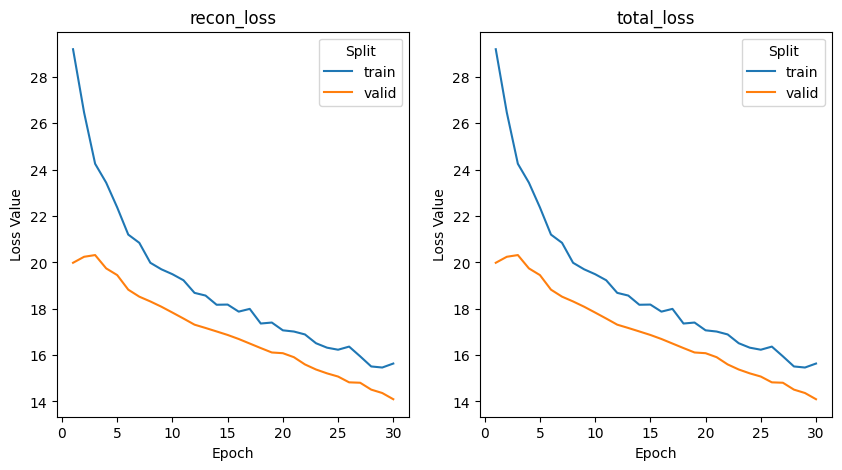

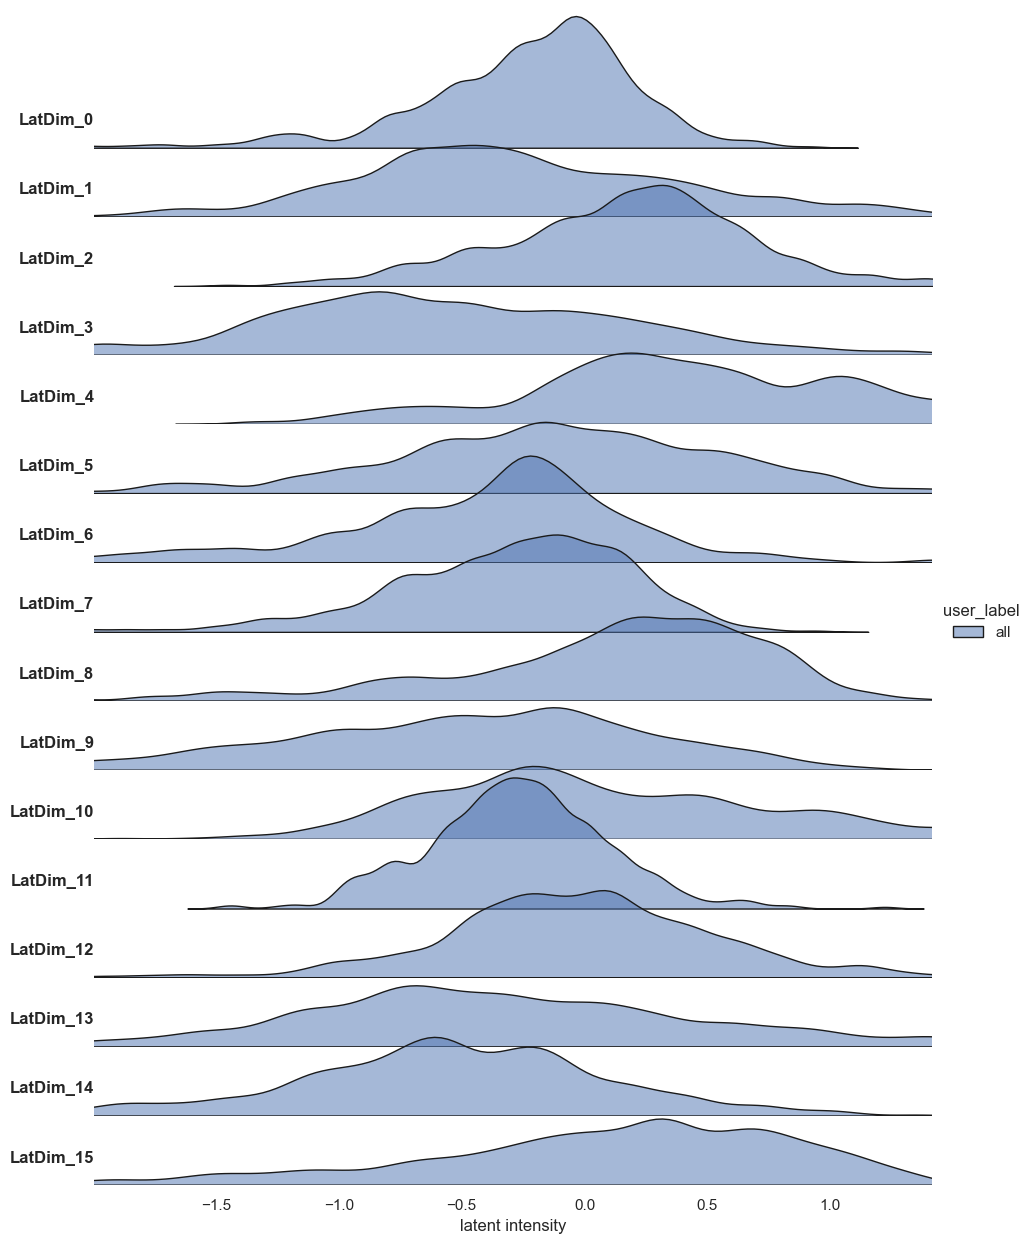

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


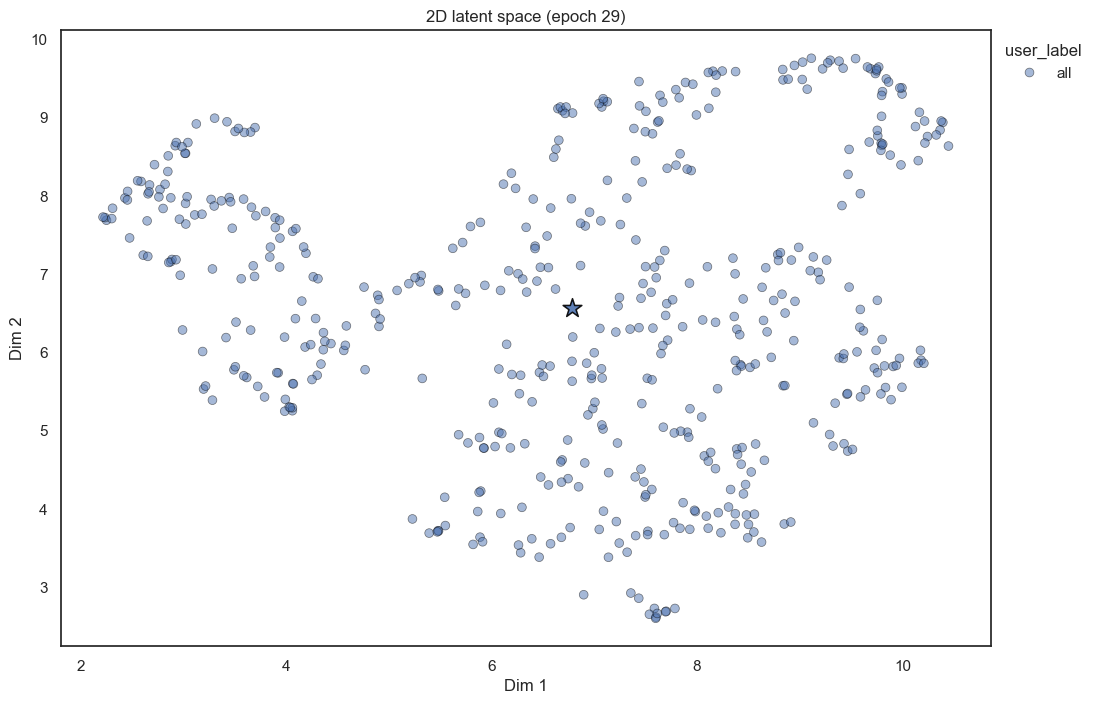

In [11]:
vanillix.show_result()

## 5) Customize

To customize the behavior of our pipeline, you adjust the configuration.  
There are two ways to work with the config:

1. Create a customized instance of the config class.  
2. Provide a `yaml` file and use the config class to read it.  

We will focus on option 1 and show a few examples. For a deeper dive into configurations, please refer to [4].  

In this section, we demonstrate how to change the following:  
- Scaling method  
- Number of layers in the autoencoder  
- Number of epochs  
- Learning rate  
- Latent dimensions  
- Retrieve information about all config parameters  

[4] Tutorials/DeepDives/ConfigTutorial.ipynb <br>


Each pipeline (Vanillix, Varix, Stackix, …) has a corresponding configuration class.  
All configuration classes inherit from a common `DefaultConfig` class, which defines all customizable parameters.  
Child classes override only those parameters that have proven to be sensible defaults for their specific pipeline.


In [12]:
from autoencodix.configs import VanillixConfig
# we simply import the specific config an init it with custom parameters
custom_config = VanillixConfig(
    scaling="MINMAX", n_layers=4, epochs=23, learning_rate=1e4, latent_dim=4, data_case="Multi Bulk"
)
# to see a list of all parameters and defaults use:
custom_config.print_schema()


VanillixConfig Configuration Parameters:
--------------------------------------------------

data_config:
  Type: <class 'autoencodix.configs.default_config.DataConfig'>
  Default: data_info={} require_common_cells=False annotation_columns=None
  Description: No description available

requires_paired:
  Type: typing.Optional[bool]
  Default: PydanticUndefined
  Description: Indicator if the samples for the xmodalix are paired, based on some sample id

data_case:
  Type: typing.Optional[autoencodix.configs.default_config.DataCase]
  Default: PydanticUndefined
  Description: Data case for the model, will be determined automatically

k_filter:
  Type: typing.Optional[int]
  Default: 20
  Description: Number of features to keep

scaling:
  Type: typing.Literal['STANDARD', 'MINMAX', 'ROBUST', 'MAXABS', 'NONE']
  Default: STANDARD
  Description: Setting the scaling here for all data modalities, can per overruled by setting scaling at data modality level per data modality

skip_preprocessing

In [13]:
# next we pass the config to our pipeline object
vanillix2 = acx.Vanillix(data=my_datapackage, config=custom_config)

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>



## 6) Re-use, Save, Load

Lastly, we show how to re-use a trained pipeline, as well as how to save and load it.  
You can do the following:

- Use the trained pipeline to run the `predict` step with new data.  
- Obtain the latent space, apply transformations, and run the `decode` step of the trained pipeline.  
- Access the underlying PyTorch model and re-use it in any way you like.  
- Store the pipeline on disk or in the cloud, then reload it and continue using it.  


#### Run with New Data

In [14]:
# for demonstration purposes we use the datapackage from step 1 again
# in real world scenarios you would use different data
result_new_data = vanillix.predict(data=my_datapackage)

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
n_samples in format recon: 500
train
test
n_samples from datatpackge: {'paired_count': 500}


#### Decode with latent space shift

In [15]:
import numpy as np
import torch
latent = result.latentspaces.get(split="test", epoch=-1)
latent_shift = np.random.normal(0, 0.1, latent.shape)
new_latent = (latent + latent_shift).astype(np.float32)
vanillix.decode(torch.from_numpy(new_latent))

tensor([[-0.7092, -0.7475, -0.5578,  ..., -1.1267, -0.6063, -0.5288],
        [-0.7279, -0.4487, -0.4741,  ..., -0.8805, -0.5641, -0.4359],
        [ 0.0690,  0.1156,  0.1285,  ...,  0.1588, -0.0080,  0.0974],
        ...,
        [-0.8502,  0.0034, -0.4878,  ..., -0.5750, -0.5686, -0.3731],
        [-0.5126,  0.0950, -0.2113,  ..., -0.2309, -0.4046, -0.2166],
        [ 0.0776,  0.0979,  0.1391,  ...,  0.1464,  0.0413,  0.0905]],
       device='mps:0')

#### Obtain PyTorch Model

In [16]:
model = result.model
# then do something with the model
print(model)

VanillixArchitecture(
  (_encoder): Sequential(
    (0): Linear(in_features=20, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.1, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=16, bias=True)
    (9): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.1, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=16, out_features=16, bias=True)
  )
  (_decoder): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=16, out_feature

#### Save and Load

In [ ]:
import os
import glob

outpath = os.path.join("tutorial_res", "van.pkl")
vanillix.save(file_path=outpath)

folder = os.path.dirname(outpath)
pkl_files = glob.glob(os.path.join(folder, "*.pkl"))
model_files = glob.glob(os.path.join(folder, "*.pth"))

print("PKL files:", pkl_files)
print("Model files:", model_files)

# the load functionality automatically will build the pipeline object out of the three saved files
vanillix_loaded = acx.Vanillix.load("van.pkl")

Pipeline object saved successfully.
Preprocessor saved successfully.
Model state saved successfully.
PKL files: ['tutorial_res/gaga/van.pkl_preprocessor.pkl', 'tutorial_res/gaga/van.pkl']
Model files: ['tutorial_res/gaga/van.pkl_model.pth']
Attempting to load a pipeline from van.pkl...
Pipeline object loaded successfully. Actual type: Vanillix
Preprocessor loaded successfully.
Model state loaded successfully.
